In [1]:
import pandas as pd
import numpy as np
import os
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import col

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import click

import spacy
import nltk

from nltk.tokenize import word_tokenize
from scispacy.abbreviation import AbbreviationDetector

import string

import keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

#nltk.download('all')
%matplotlib inline 

In [2]:
# Table 1
spark.sql("use standaardtabellen")
NASA_totaal = spark.sql("select * from nasastandaardtabel")
NASA_totaal = NASA_totaal.select(col("NASA_NR"), col("PRIMARY_EAN").alias("ARTIKEL_EAN"), col("GLN").alias("gln_nasa"), col("SCHAPSTICKER_OMSCHRIJVING"),col("ASSGROEP_OMSCHRIJVING"), col("KASSABON_OMSCHRIJVING"), col("LANGE_OMSCHRIJVING"), col("EENHEID")
                                , col("INHOUD"))
# Table 2
GLNAH = spark.read.format('delta').load('/mnt/Prd_adls/Conformed/TIMS/TradeItem/ahTradeItem/Data/').filter('__DeletedFlag == 0')
GLNAH = GLNAH.select(col("gtin").alias("gtin1"), col("gln").alias('gln1'), col("glnAH"), col("ndDepartment"))

# Table 3
spark.read.format('delta').load('/mnt/Prd_adls/Conformed/TIMS/TradeItem/tradeItemInfo/Data/').filter('__DeletedFlag == 0').registerTempTable('tradeItemInfo')
tradeItemInfo = spark.sql("select gtin, gln, coalesce (tradeItemInfo.mvlang_tradeItemDescMod_tradeItemDescInfo_tradeItemDesc['nl'], tradeItemInfo.mvlang_tradeItemDescMod_tradeItemDescInfo_tradeItemDesc['en']) as TradeItemDescr, coalesce(lang_tradeItemDescMod_tradeItemDescInfo_functionalName['nl'], lang_tradeItemDescMod_tradeItemDescInfo_functionalName['en']) as functionalName, coalesce(mvlang_tradeItemDescMod_tradeItemDescInfo_labelDesc['nl'], mvlang_tradeItemDescMod_tradeItemDescInfo_labelDesc['en']) as labelDescription, coalesce(mvlang_tradeItemDescMod_tradeItemDescInfo_regulatedProdName['nl'], mvlang_tradeItemDescMod_tradeItemDescInfo_regulatedProdName['en']) as regulatedProdName, coalesce(mvlang_foodAndBeverageIngredientMod_ingredientStatement['nl'], mvlang_foodAndBeverageIngredientMod_ingredientStatement['en']) as ingredientStatement from tradeItemInfo")
# coalesce, returned de eerste non-null value in een list


# Join several Tables
NASA_totaal = NASA_totaal.join(GLNAH, (NASA_totaal.ARTIKEL_EAN == GLNAH.gtin1) & (NASA_totaal.gln_nasa == GLNAH.gln1), how = "left")
NASA_totaal = NASA_totaal.join(tradeItemInfo, (NASA_totaal.ARTIKEL_EAN == tradeItemInfo.gtin) & (NASA_totaal.gln_nasa == tradeItemInfo.gln), how = "left")
print((NASA_totaal.count(),len(NASA_totaal.columns))) 
NASA_totaal = NASA_totaal.filter(NASA_totaal.glnAH == True)

# Select Features
NASA = NASA_totaal.select("ARTIKEL_EAN", "gln_nasa","glnAH","regulatedProdName","functionalName", "labelDescription","TradeItemDescr","ingredientStatement",)
NASA = NASA.withColumnRenamed("ARTIKEL_EAN", "gtin") # hernoem naar gtin, zodat we department kunnen mergen.
NASA = NASA.withColumnRenamed("gln_nasa", "gln") # hernoem naar gtin, zodat we department kunnen mergen.
print("Shape van DF (row, columns) ",(NASA.count(),len(NASA.columns))) # Shape of dataframe

# Arrays naar strings
NASA = NASA.withColumn("regulatedProdName", concat_ws(" ", "regulatedProdName"))
NASA = NASA.withColumn("functionalName", concat_ws(" ", "functionalName"))
NASA = NASA.withColumn("labelDescription", concat_ws(" ", "labelDescription"))
NASA = NASA.withColumn("TradeItemDescr", concat_ws(" ", "TradeItemDescr"))
NASA = NASA.withColumn("ingredientStatement", concat_ws(" ", "ingredientStatement"))

display(NASA.limit(1))

/databricks/spark/python/pyspark/sql/dataframe.py:146: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
 warnings.warn(
(48956, 20)
Shape van DF (row, columns) (35037, 8)

gtin,gln,glnAH,regulatedProdName,functionalName,labelDescription,TradeItemDescr,ingredientStatement
3159470001424,38000000072,true,"Ontbijtgranen van tarwezemelen, van nature uit rijk aan vezels (27%), verrijkt met vitaminen (B₁, B₂, niacine, B₆, foliumzuur, B₁₂) en ijzer.",Ontbijtgranen,Kellogg's All-Bran Plus 500 g,Kellogg's ALL BRAN FLAKES 500g,"Ingrediënten: TARWEZEMELEN (87%), suiker, GERSTEMOUTAROMA, zout, Vitaminen en mineralen: vitaminen (niacine, B6, B2, B1, foliumzuur, B12), ijzer. Allergenen: zie ingrediëntenlijst, in vet gemarkeerd."


In [3]:
NASA = NASA.filter(NASA.glnAH == True)
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_pandas = NASA.toPandas()

df_pandas = df_pandas.astype({"regulatedProdName":"string", "functionalName":"string","labelDescription":"string","TradeItemDescr":"string","ingredientStatement":"string"}) # object to string
df_NLP = df_pandas[['gtin','gln','regulatedProdName','functionalName','labelDescription','TradeItemDescr','ingredientStatement']].copy()

In [4]:
text_features = ['regulatedProdName','functionalName','labelDescription','TradeItemDescr','ingredientStatement']
for TEXT_F in text_features:
    df_NLP[str(TEXT_F)] = df_NLP[TEXT_F].apply(lambda x: len(x.split()))

In [5]:
display(df_NLP.head())

gtin,gln,regulatedProdName,functionalName,labelDescription,TradeItemDescr,ingredientStatement
3159470001424,38000000072,21,1,5,5,23
3159470005347,38000000072,13,1,8,3,54
3159470200087,38000000072,13,1,6,6,41
3159470202166,38000000072,12,1,7,6,41
4003994152508,38000000072,8,1,6,4,37


Out[33]:

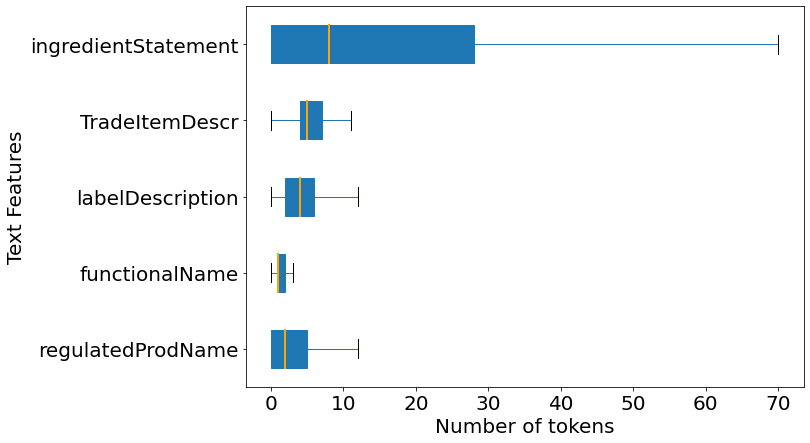

Text(0.5, 0, 'Number of tokens')

In [6]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
plt.rcParams.update({'font.size': 20})
medianprops = dict(linestyle='-', linewidth=2, color='orange')
bbplot = df_NLP.boxplot(column=['regulatedProdName','functionalName','labelDescription','TradeItemDescr','ingredientStatement'], showfliers=False, vert=False, grid=False, patch_artist=True, medianprops=medianprops)


bbplot.set_ylabel('Text Features')
bbplot.set_xlabel('Number of tokens')